In [ ]:
# Установка библиотек

!pip install streamlit -q

In [ ]:
# Импорт библиотек

import joblib
import numpy as np
import pandas as pd
from math import sqrt
import streamlit as st
from joblib import dump

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

In [ ]:
# Загрузка данных

df = pd.read_csv('main_data.csv')

df.head()

,region,address,price,total_area,kitchen_area,living_area,rooms_count,floor,floors_number,build_date,isСomplete,complitation_year,house_material,parking,decoration,balcony,longitude,latitude,passenger_elevator,cargo_elevator,metro,metro_distance,metro_transport,district,is_apartments,is_auction
0,msk,"Москва, Большой Толмачёвский переулок",1996610000,459.4,81.4,173.3,5.0,7,8,NaN,0.0,2024.0,monolith,underground,NaN,4.0,37.620949,55.739757,1.0,1.0,"Полянка,Новокузнецкая,Третьяковская","6,10,4","walk,walk,transport","Якиманка,ЦАО",0.0,0
1,msk,"Москва, Самотечная ул., 5",66970000,160.0,25.0,119.0,3.0,3,9,1892.0,NaN,NaN,brick,underground,NaN,0.0,37.618318,55.775165,1.0,1.0,"Цветной бульвар,Достоевская,Сухаревская","6,9,13","walk,walk,walk","Тверской,ЦАО",NaN,1
2,msk,"Москва, Ильинка",378820000,157.4,41.1,50.7,3.0,3,5,NaN,0.0,2024.0,monolith,NaN,NaN,NaN,37.623649,55.755140,NaN,NaN,"Площадь Революции,Театральная","3,6","walk,walk","Тверской,ЦАО",0.0,0
3,msk,"Москва, М. Бронная ул., 32",110500000,110.5,15.0,61.0,3.0,2,6,1912.0,NaN,NaN,brick,ground,NaN,0.0,37.593524,55.764197,1.0,0.0,"Маяковская,Пушкинская,Тверская","10,10,10","walk,walk,walk","Пресненский,ЦАО",NaN,1
4,msk,"Москва, Ильинка",1031300000,271.8,57.1,123.8,5.0,5,5,NaN,0.0,2024.0,monolith,NaN,NaN,NaN,37.623509,55.755201,NaN,NaN,"Площадь Революции,Театральная","3,6","walk,walk","Тверской,ЦАО",0.0,0


## **Разведочный анализ данных**

In [ ]:
# Размер датафрейма

df.shape

(5978, 26)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5978 entries, 0 to 5977
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   region              5978 non-null   object 
 1   address             5978 non-null   object 
 2   price               5978 non-null   int64  
 3   total_area          5978 non-null   float64
 4   kitchen_area        3702 non-null   float64
 5   living_area         3834 non-null   float64
 6   rooms_count         5248 non-null   float64
 7   floor               5978 non-null   int64  
 8   floors_number       5978 non-null   int64  
 9   build_date          1497 non-null   float64
 10  isСomplete          3797 non-null   float64
 11  complitation_year   3869 non-null   float64
 12  house_material      5371 non-null   object 
 13  parking             1432 non-null   object 
 14  decoration          1222 non-null   object 
 15  balcony             1405 non-null   float64
 16  longit

In [ ]:
# Явные дубликаты

df.duplicated().sum()

0

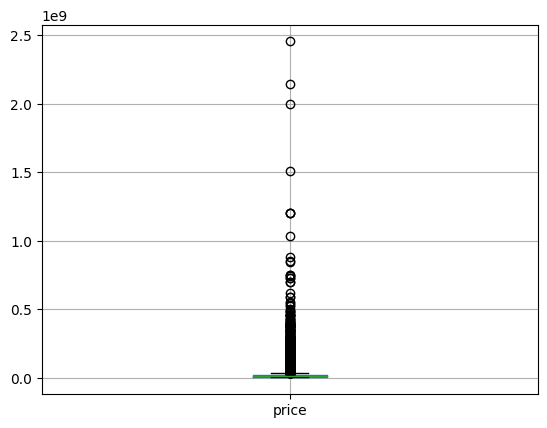

In [ ]:
# Изучим целевую переменную

df.boxplot('price');

In [ ]:
# Обрежем выбросы - оставим только те значения, что попадают в квантиль 0.95

df = df[df.price < df.price.quantile(q=0.95)]
df.shape

(5678, 26)

In [ ]:
# Кол-во пропусков

df.isna().sum()

region                   0
address                  0
price                    0
total_area               0
kitchen_area          2183
living_area           2012
rooms_count            723
floor                    0
floors_number            0
build_date            4340
isСomplete            1929
complitation_year     1859
house_material         564
parking               4435
decoration            4484
balcony               4359
longitude                0
latitude                 0
passenger_elevator    2618
cargo_elevator        3057
metro                  858
metro_distance         858
metro_transport        858
district                17
is_apartments          877
is_auction               0
dtype: int64

In [ ]:
# Изучение пропусков в столбце isComplete (достроен ли дом)

df['isСomplete'].value_counts()

0.0    3252
1.0     497
Name: isСomplete, dtype: int64

In [ ]:
# Заполнение пропусков в столбце isComplete

# Если дата постройки дома (build_date) < 2024, то дом построен
df.loc[df['build_date'].fillna(2025).astype(int) < 2024, 'isСomplete'] = 1
# Если дата окончания строительства (complitation_year) > 2024, то дом не построен
df.loc[df['complitation_year'].fillna(2023).astype(int) > 2024, 'isСomplete'] = 0

print('После:', df.isСomplete.value_counts())

После: 0.0    3271
1.0    1813
Name: isСomplete, dtype: int64


In [ ]:
# Проверка корректности заполнения

df.head()

,region,address,price,total_area,kitchen_area,living_area,rooms_count,floor,floors_number,build_date,isСomplete,complitation_year,house_material,parking,decoration,balcony,longitude,latitude,passenger_elevator,cargo_elevator,metro,metro_distance,metro_transport,district,is_apartments,is_auction
1,msk,"Москва, Самотечная ул., 5",66970000,160.0,25.0,119.0,3.0,3,9,1892.0,1.0,NaN,brick,underground,NaN,0.0,37.618318,55.775165,1.0,1.0,"Цветной бульвар,Достоевская,Сухаревская","6,9,13","walk,walk,walk","Тверской,ЦАО",NaN,1
3,msk,"Москва, М. Бронная ул., 32",110500000,110.5,15.0,61.0,3.0,2,6,1912.0,1.0,NaN,brick,ground,NaN,0.0,37.593524,55.764197,1.0,0.0,"Маяковская,Пушкинская,Тверская","10,10,10","walk,walk,walk","Пресненский,ЦАО",NaN,1
10,msk,"Москва, Софийская набережная, 36",109213650,127.0,NaN,NaN,3.0,3,7,NaN,1.0,2022.0,NaN,NaN,NaN,NaN,37.623959,55.747611,4.0,4.0,"Новокузнецкая,Третьяковская,Китай-город","11,11,15","walk,walk,walk","Якиманка,ЦАО",1.0,0
14,msk,"Москва, 1-я Тверская-Ямская улица, 2",85974000,62.3,23.7,NaN,2.0,8,9,NaN,1.0,2022.0,monolith,underground,fine,NaN,37.594868,55.771088,NaN,NaN,"Маяковская,Тверская,Пушкинская","1,10,11","walk,walk,walk","Тверской,ЦАО",1.0,0
18,msk,"Москва, Лужнецкая набережная",52569000,49.8,NaN,27.9,2.0,9,17,NaN,0.0,2026.0,monolith,multilevel,without,NaN,37.571184,55.715275,1.0,1.0,"Воробьёвы горы,Лужники,Спортивная","12,18,20","walk,walk,walk","Хамовники,ЦАО",0.0,0


In [ ]:
df = df[['region', 'price', 'total_area', 'floor', 'floors_number', 'longitude', 'latitude', 'is_auction']]

In [ ]:
df.isna().sum()

region           0
price            0
total_area       0
floor            0
floors_number    0
longitude        0
latitude         0
is_auction       0
dtype: int64

## **Построение модели**

In [ ]:
# Разделение выборки на трейн и тест

features = df.drop(['price'], axis=1)
target = df['price']

features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=0.1,
                                                                            random_state=42)

# Разделение признаков на численные и категориальные
features_train_cat = features_train[['region']]
features_test_cat = features_test[['region']]
features_train_num = features_train[['total_area', 'floor', 'floors_number', 'longitude', 'latitude', 'is_auction']]
features_test_num = features_test[['total_area', 'floor', 'floors_number', 'longitude', 'latitude', 'is_auction']]

In [ ]:
# Кодирование признаков

encoder = OneHotEncoder(sparse=False)
encoder.fit(features_train_cat)
dump(encoder, 'encoder.joblib')

features_train_encoded = pd.DataFrame(encoder.transform(features_train_cat),
                                      columns = encoder.get_feature_names_out(features_train_cat.columns))
features_test_encoded = pd.DataFrame(encoder.transform(features_test_cat),
                                     columns = encoder.get_feature_names_out(features_test_cat.columns))

features_train = pd.concat([features_train_encoded.reset_index(drop=True),
                            features_train_num.reset_index(drop=True)], axis=1)
features_test = pd.concat([features_test_encoded.reset_index(drop=True),
                           features_test_num.reset_index(drop=True)], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
features_train.head()

,region_ekb,region_kzn,region_msk,region_nng,region_nsk,region_spb,total_area,floor,floors_number,longitude,latitude,is_auction
0,0.0,0.0,0.0,0.0,1.0,0.0,41.00,10,10,82.968768,54.946664,1
1,0.0,0.0,0.0,0.0,1.0,0.0,41.60,25,25,82.963854,55.016105,0
2,0.0,0.0,0.0,1.0,0.0,0.0,52.40,10,14,43.845673,56.286675,0
3,0.0,0.0,0.0,0.0,1.0,0.0,38.63,14,29,82.859746,55.046375,0
4,0.0,0.0,0.0,0.0,1.0,0.0,31.75,4,12,82.966649,55.040057,0


In [ ]:
# Построение модели

model_LR = LinearRegression()
model_LR.fit(features_train, target_train)
dump(model_LR, 'model_lr.joblib')

['model_lr.joblib']

$$\text{RMSE} = \sqrt{\frac{\sum_{i=1}^{n}(\hat{y}_i - y_i)^2}{n}}$$


In [ ]:
# Оценка модели

predict_LR = model_LR.predict(features_test)
rmse = sqrt(mean_squared_error(target_test, predict_LR))

rmse

10661376.00274095

## **Веб-интерфейс**

In [ ]:
total_area = 40
floor = 10
floors_number = 15
longitude = 49.14
latitude = 55.81
is_auction = 0
region = 'kzn'

model = joblib.load('model_lr.joblib')
encoder = joblib.load('encoder.joblib')

columns = ['region', 'total_area', 'floor', 'floors_number', 'longitude', 'latitude', 'is_auction']

def predict():
  row = np.array([region, total_area, floor, floors_number, longitude, latitude, is_auction])
  X = pd.DataFrame([row], columns=columns)
  # display(X)
  X_cat = X[['region']]
  X_num = X[['total_area', 'floor', 'floors_number', 'longitude', 'latitude', 'is_auction']]

  encoder = joblib.load('encoder.joblib')
  X_encoded = pd.DataFrame(encoder.transform(X_cat),
                           columns = encoder.get_feature_names_out(X_cat.columns))

  X = pd.concat([X_encoded.reset_index(drop=True),
                 X_num.reset_index(drop=True)], axis=1)

  return model.predict(X)[0]


predict()

6991141.9595223665

In [ ]:
# Запускаем утилиту wget для получения внешнего IP-адреса от сервиса ipv4.icanhazip.com

!wget -q -O - ipv4.icanhazip.com

34.125.69.192


In [ ]:
# Запускает приложение streamlit (файл приложения app.py)

!streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.69.192:8501

npx: installed 22 in 2.991s
your url is: https://famous-terms-heal.loca.lt
  Stopping...
^C


In [ ]:
# Перенести в файл app.py перед запуском streamlit

import joblib
import numpy as np
import pandas as pd
import streamlit as st
from joblib import dump

model = joblib.load('model_lr.joblib')
encoder = joblib.load('encoder.joblib')

st.title('Предсказание цены на недвижимость')

region = st.selectbox('Регион', ('msk', 'spb', 'ekb', 'nsk', 'kzn', 'nng'))
total_area = st.number_input('Площадь, кв.м.')
floor = st.number_input('Этаж')
floors_number = st.number_input('Кол-во этажей в доме')
longitude = st.number_input('Долгота, град')
latitude = st.number_input('Широта, град')
is_auction = st.number_input('Находится ли квартира на аукционе?')

columns = ['region', 'total_area', 'floor', 'floors_number',
           'longitude', 'latitude', 'is_auction']

def predict():
  row = np.array([region, total_area, floor, floors_number, longitude, latitude, is_auction])
  X = pd.DataFrame([row], columns=columns)
  X_cat = X[['region']]
  X_num = X[['total_area', 'floor', 'floors_number', 'longitude', 'latitude', 'is_auction']]

  encoder = joblib.load('encoder.joblib')
  X_encoded = pd.DataFrame(encoder.transform(X_cat),
                           columns = encoder.get_feature_names_out(X_cat.columns))

  X = pd.concat([X_encoded.reset_index(drop=True),
                 X_num.reset_index(drop=True)], axis=1)

  return model.predict(X)[0]


if st.button("Предсказание"):
    st.success(predict())

2024-03-11 13:58:50.939 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
